In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
import scipy.misc
print(torch.__version__)


0.4.1


In [2]:
device = torch.device('cuda:1'if torch.cuda.is_available()else 'cpu')

In [3]:
 
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.13,), (0.308,))])
 

In [4]:
epochs = 5;
lr = 0.0001;
batch_size = 64;
num_classes = 10;

In [5]:
train_dataset = torchvision.datasets.MNIST(root = '/home/anil/data',train =True,transform = transform,download = True)
test_dataset = torchvision.datasets.MNIST(root='home/anil/data',
                                          train=False, 
                                          transform=transform,download = True)



In [6]:
valid_dataset = torchvision.datasets.MNIST(root = '/home/anil/data',train =True,transform = transform,download = True)

In [7]:
num_train = len(train_dataset)
indices = list(range(num_train))
split=int(np.floor(0.2*num_train))

In [8]:
tr_idx,valid_idx = indices[split:],indices[:split]


In [9]:
np.random.seed(0)
np.random.shuffle(indices)

In [10]:
trainsampler = SubsetRandomSampler(tr_idx)
validsampler = SubsetRandomSampler(valid_idx)


In [11]:
trainloader = torch.utils.data.DataLoader(dataset = train_dataset,sampler = trainsampler,batch_size = batch_size,shuffle = False)
testloader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size , shuffle=True)
validloader = torch.utils.data.DataLoader(dataset = train_dataset,sampler = validsampler,batch_size = batch_size,shuffle = False)

In [12]:
#to show image
def process_normal_img(img):
    img = img*0.3081+0.1307
    npimg = img.numpy()
    return (np.transpose(npimg,(1,2,0)))

In [13]:
def process_network_img(img):
    npimg = img.detach().numpy
    return (np.transpose(npimg,(1,2,0)))

In [14]:
class ConvNet(nn.Module):
     def __init__(self,num_classes = 10):
            super (ConvNet,self).__init__()
            self.layer1 = nn.Sequential(
                   nn.Conv2d(1, 32 , kernel_size =3 , stride = 1, padding = 1), #25088
                   nn.BatchNorm2d(32),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size = 2, stride = 2))
            self.layer2 = nn.Sequential(
                   nn.Conv2d(32,32,kernel_size = 3 , stride = 1,padding = 1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size = 2 , stride = 2))
            self.fc1 = nn.Linear(7*7*32,500)
            self.fc2 = nn.Linear(500,10)
            
    
     def forward(self,x):
            x1 = self.layer1(x)
            x2 = self.layer2(x1)
            out = x2.reshape(x2.size(0),-1)
            out = self.fc1(out)
            out = self.fc2(out)
            return(x1,x2,out)

In [15]:
model = ConvNet()
print(model)


ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr= lr)


In [17]:
def valid_accuracy(validloader,model):
    correct= 0
    total = 0
    tot_loss = 0
    with torch.no_grad():
        for data in validloader:
            images,labels = data
            #print(images.size())
            _,_,out = model(images)
            _,predicted = torch.max(out.data,1)
            loss = criterion(out,labels)
            tot_loss = tot_loss+loss.item()
            total=total+labels.size(0)
            #correct = correct+(predicted == labels).sum().item()
    #val_acc = (100*correct/total)
    print('Validation loss:%f '%(tot_loss))
    return (tot_loss)
    #print('Accuracy on validation set: %d %%'%val_acc)

In [18]:
def test_accuracy(testloader,model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            _,_,output = model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc = (100 * correct / total)
    print('Accuracy of the network on test set: %d %%' % test_acc)
    return(test_acc)
    

In [19]:
val_loss = [];
test_acc = [];
train_loss = [];
running_loss = 0;
for epoch in range(3):
    for i,data in enumerate(trainloader,0):
        images,labels = data
        images.size()
        _,_,out = model(images)
        _,predicted =torch.max(out.data,1)
        loss = criterion(out,labels)
        optimizer.zero_grad()
        loss.backward()      #backpropagate loss
        optimizer.step()     #updating weights
       
       
        
        running_loss =running_loss +loss.item()
        
        
        
        
        if(i%50==49):   #50 mini batches
            print('[%d,%5d] loss: %0.3f'%(epoch+1,i+1,running_loss/50))
            train_loss.append((running_loss/50))
            running_loss = 0
            v_loss = valid_accuracy(validloader,model)
            val_loss.append(v_loss)
            print('Finished training')
            t_ac = test_accuracy(testloader,model)
            test_acc.append(t_ac)
            

    
    
        
    

[1,   50] loss: 1.762
Validation loss:198.230824 
Finished training
Accuracy of the network on test set: 81 %
[1,  100] loss: 0.711
Validation loss:92.934599 
Finished training
Accuracy of the network on test set: 87 %
[1,  150] loss: 0.415
Validation loss:67.164219 
Finished training
Accuracy of the network on test set: 90 %
[1,  200] loss: 0.326
Validation loss:54.356167 
Finished training
Accuracy of the network on test set: 92 %
[1,  250] loss: 0.289
Validation loss:46.598520 
Finished training
Accuracy of the network on test set: 93 %
[1,  300] loss: 0.237
Validation loss:40.676804 
Finished training
Accuracy of the network on test set: 94 %
[1,  350] loss: 0.218
Validation loss:38.336433 
Finished training
Accuracy of the network on test set: 94 %
[1,  400] loss: 0.173
Validation loss:35.373831 
Finished training
Accuracy of the network on test set: 94 %
[1,  450] loss: 0.163
Validation loss:34.386470 
Finished training
Accuracy of the network on test set: 95 %
[1,  500] loss: 0.

In [25]:
modelroot = '/home/anil/data/MNIST/MNISTsaved/saved_model2'

In [27]:
torch.save(model.state_dict(), modelroot)

In [22]:
for name, param in model.named_parameters():
    print(name)
    print(param.numel())

layer1.0.weight
288
layer1.0.bias
32
layer1.1.weight
32
layer1.1.bias
32
layer2.0.weight
9216
layer2.0.bias
32
fc1.weight
784000
fc1.bias
500
fc2.weight
5000
fc2.bias
10


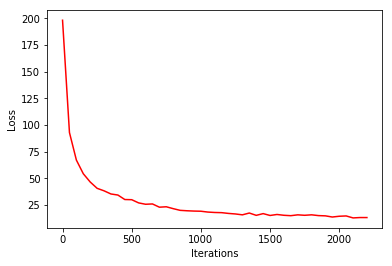

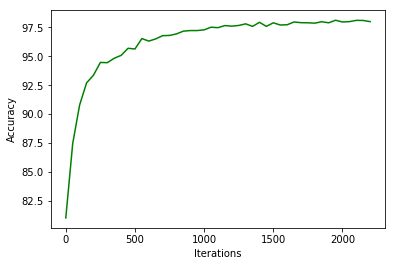

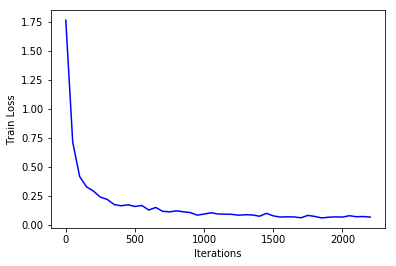

In [23]:
x=list(range(0,2250,50))
plt.plot(x,val_loss,'r',label ='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()
plt.plot(x,test_acc,'g',label = 'Test Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.show()

plt.plot(x,train_loss,'b')
plt.xlabel('Iterations')
plt.ylabel('Train Loss')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


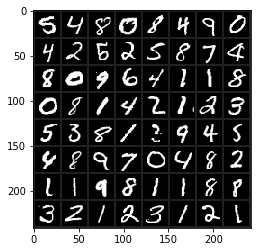

In [28]:
#reloading
model.load_state_dict(torch.load(modelroot))
data = iter(trainloader)
images,labels = data.next()
trainimages = process_normal_img(torchvision.utils.make_grid(images))
plt.imshow(trainimages)

In [29]:
classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')
print('Actual Labels')
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))


print('Predicted Labels')
_,_,out =model(images)

_, predicted = torch.max(out.data, 1)
print(' '.join('%5s' % classes[predicted[j]] for j in range(batch_size)))

Actual Labels
    5     4     8     0     8     4     9     0     4     2     5     2     5     8     7     4     8     0     9     6     4     1     1     8     0     8     1     4     2     1     2     3     5     3     8     1     3     9     4     5     4     8     9     7     0     4     8     2     1     1     9     8     1     1     8     8     3     2     1     2     3     1     2     1
Predicted Labels
    5     4     8     0     8     4     9     0     4     2     5     2     5     8     7     4     8     0     9     6     4     1     1     8     0     8     1     4     2     1     2     3     5     3     8     1     3     9     4     5     4     8     9     7     0     4     8     2     1     1     9     8     1     1     8     8     3     2     1     2     3     1     2     1
